In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['pickled-glove840b300d-for-10sec-loading', 'bert-pretrained-models', 'data-vahan', 'ppbert']


In [2]:
 !pip install googletrans #for translating non english to english

  Created wheel for googletrans: filename=googletrans-2.4.0-cp36-none-any.whl size=15776 sha256=5d121b88004e10cc25cc1e7130b48f98fc6d9da28380a6745c9a59e1d4966f1d
  Stored in directory: /tmp/.cache/pip/wheels/50/d6/e7/a8efd5f2427d5eb258070048718fa56ee5ac57fd6f53505f95
Successfully built googletrans


In [3]:
!pip install emoji #for emoji removal

In [4]:
import yaml
import re
import emoji


In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import datetime
import pkg_resources
import seaborn as sns
import time
import scipy.stats as stats
import gc
import re
import operator 
import sys
from sklearn import metrics
from sklearn import model_selection
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from nltk.stem import PorterStemmer
from sklearn.metrics import roc_auc_score
%load_ext autoreload
%autoreload 2
%matplotlib inline
from tqdm import tqdm, tqdm_notebook
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings(action='once')
import pickle
#from apex import amp
import shutil
tqdm.pandas()

In [6]:
data = pd.read_csv('../input/data-vahan/TakeHome_task_data.csv')

In [7]:
processed_data=pd.DataFrame(columns=["id","data","message_order","comments"])

In [8]:
#to get data from the the first column
for i in range(len(data)):
    row=[]
    k=yaml.load(data['data'][i])
    row.append(k["id"])
    row.append(k["data"])
    row.append(k["message_order"])
    row.append(k["comments"])
    
    processed_data.loc[i]=row
    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


In [9]:
processed_data['label']=data['label']

In [10]:
data=processed_data
del processed_data

In [11]:
data=data.astype({"id":str,"data":str,"message_order":int,"comments":str})

In [12]:
data[:]["id"].describe()

count       2000
unique      1999
top       SJZI46
freq           2
Name: id, dtype: object

In [13]:
data[:]["comments"].describe()

count     2000
unique       1
top       ['']
freq      2000
Name: comments, dtype: object

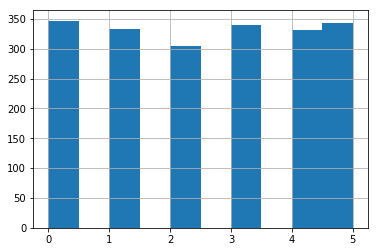

In [14]:
data[:]["message_order"].hist()

In [15]:
data['label'].value_counts().to_dict()

{'whoAreYou': 627,
 'greeting': 619,
 'notInterested': 474,
 'dontMeetRequirements': 160,
 'location': 120}

In [16]:
data=data.drop('id',1)
data=data.drop('comments',1)

In [17]:
from googletrans import Translator #to translate

In [18]:
#emoji removal
def give_emoji_free_text(text):
    clean_text=''
    allchars = [str for str in text]
    clean_text=clean_text.join([c for c in allchars if c not in emoji.UNICODE_EMOJI ])
    return clean_text


In [19]:
data['data']=data['data'].apply(give_emoji_free_text)

In [20]:
data

,data,message_order,label
0,Good morning,2,location
1,Location,5,whoAreYou
2,hi,5,whoAreYou
3,Hi,4,greeting
4,Hello,1,greeting
5,sir,3,whoAreYou
6,K,2,whoAreYou
7,On thanks,2,dontMeetRequirements
8,Hii,3,dontMeetRequirements
9,Sir I dnt have two wheeler,2,whoAreYou


In [21]:
#to remove few leftover emoji
def remove_emoji(string):
    emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [22]:
data['data']=data['data'].apply(remove_emoji)

In [23]:
#translating
k=list(data['data'].values)
k1=k[:1000]
k2=k[1000:]
translator = Translator()
k1=translator.translate(k1)
translator = Translator()
k2=translator.translate(k2)
k1=k1+k2


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed <socket.socket fd=49, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.19.1.2', 49648), raddr=('74.125.23.113', 443)>
  import sys


In [24]:
k=[]
for i in range(len(k1)):
    k.append(k1[i].text)
    

In [25]:
data['data'][:]=k[:]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
#preprocessing steps to increase word coverage in glove vector
def remove_multifullstop(text):
    
    return re.sub(r'\.{2,}', ' ', text)

In [27]:
data['data']=data['data'].apply(remove_multifullstop)

In [28]:
def remove_repeatedchars(text):
    pattern=re.compile(r"(.)\1{2,}",re.DOTALL)
    string=pattern.sub(r"\1",text)
    return string

In [29]:
data['data']=data['data'].apply(remove_repeatedchars)

In [30]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [31]:
def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text

In [32]:
data['data']=data['data'].apply(clean_contractions)

In [33]:
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

In [34]:
data['data']=data['data'].apply(clean_text)

In [35]:
from fastai import *
from fastai.text import * 

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [36]:
#loading data for language model and classification
data_lm = (TextList
           .from_df(data, cols='data')
           #Where are the text? Column 'text' of texts.csv
           .split_by_rand_pct()
           #How to split it? Randomly with the default 20% in valid
           .label_for_lm()
           #Label it for a language model
           .databunch())
data_clas=(TextList.from_df(data, cols='data')
                   .split_by_rand_pct()
                   .label_from_df(cols='label')
                   .databunch())

In [37]:
data_clas.train_ds

LabelList (1600 items)
x: TextList
xxbos xxmaj good morning,xxbos hi,xxbos xxmaj hi,xxbos xxmaj hello,xxbos k
y: CategoryList
location,whoAreYou,greeting,greeting,whoAreYou
Path: .

In [38]:
#AWD_LSTM language model pretrained on wikitext
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

/opt/conda/lib/python3.6/site-packages/fastai/datasets.py:212: ResourceWarning: unclosed <socket.socket fd=70, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('172.19.1.2', 60166), raddr=('52.216.95.125', 443)>
  download_url(f'{url}{ext}', fname)
/opt/conda/lib/python3.6/site-packages/fastai/text/learner.py:74: ResourceWarning: unclosed file <_io.BufferedReader name='/tmp/.fastai/models/wt103-fwd/itos_wt103.pkl'>
  old_itos = pickle.load(open(itos_fname, 'rb'))


In [39]:
print(learn)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1600 items)
x: LMTextList
xxbos xxmaj good morning,xxbos xxmaj location,xxbos hi,xxbos xxmaj hi,xxbos xxmaj hello
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (400 items)
x: LMTextList
xxbos k thank u,xxbos i do not have a xxunk,xxbos xxmaj xxunk don xxunk to this xxunk,xxbos xxmaj no i say xxunk r t nagar,xxbos xxmaj which xxunk
y: LMLabelList
,,,,
Path: .;

Test: None, model=SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(168, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(168, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDro

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


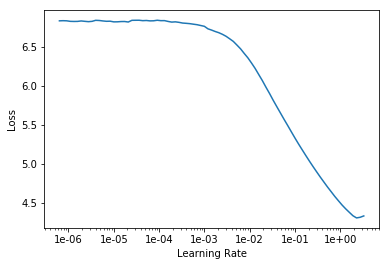

In [40]:
#to find out the best lr for fast convergence
learn.lr_find()
learn.recorder.plot()

In [41]:
#one cycle learning for super convergence with steepest downward slope lr
learn.fit_one_cycle(100, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,6.812585,6.854481,0.057366,00:00
1,6.803046,6.765022,0.059152,00:00
2,6.735734,6.671988,0.061384,00:00
3,6.676248,6.573871,0.061830,00:00
4,6.621252,6.404898,0.067857,00:00
5,6.572611,6.213529,0.071875,00:00
6,6.509712,5.995090,0.080580,00:00
7,6.428301,5.724595,0.089732,00:00
8,6.331470,5.447805,0.098438,00:00
9,6.229065,5.159523,0.112054,00:00


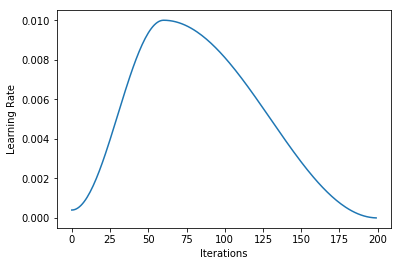

In [42]:
#one cycle policy lr profile
learn.recorder.plot_lr()

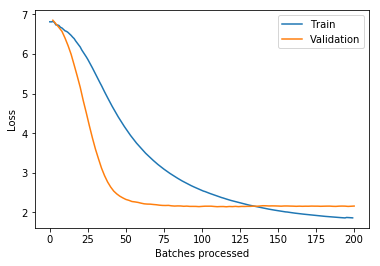

In [43]:
#loss behavior
learn.recorder.plot_losses()

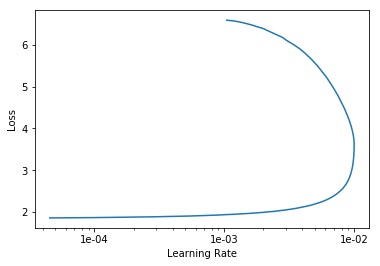

In [44]:
#to find lr so that we can unfreeze the model and train on different lr across all layers
learn.recorder.plot()

In [45]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))#for different lr for different layers

epoch,train_loss,valid_loss,accuracy,time
0,1.719294,2.155802,0.525223,00:00
1,1.721677,2.151698,0.528348,00:00
2,1.724170,2.150196,0.527455,00:00
3,1.723704,2.148269,0.525446,00:00
4,1.723428,2.156060,0.527009,00:00


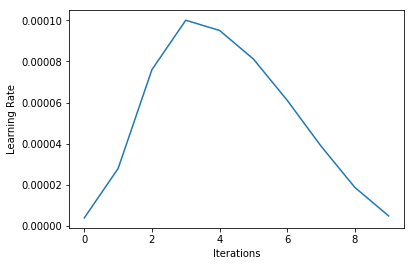

In [46]:
learn.recorder.plot_lr()

**the code below this was used to decide which preprocessing steps to take so that it increases GLOVE coverage**

GLOVE_EMBEDDING_PATH = '../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl'

import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x


def load_embeddings(path):
    with open(path,'rb') as f:
        emb_arr = pickle.load(f)
    return emb_arr


tic = time.time()
glove_embeddings = load_embeddings(GLOVE_EMBEDDING_PATH)
print(f'loaded {len(glove_embeddings)} word vectors in {time.time()-tic}s')

sentences = data["data"].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
print({k: vocab[k] for k in list(vocab)[:5]})

oov = check_coverage(vocab,glove_embeddings)
oov[:100]